<a href="https://colab.research.google.com/github/gysdnow/NLPWorks/blob/master/DocumentRetrival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information Retrieval
> [Simple Applications of BERT for Ad Hoc Document Retrieval](https://arxiv.org/pdf/1903.10972.pdf)

論文操作方式:

分別對文章中的每一個句子，計算出與 Query 的相似度分數，組合成**這篇文章**對於該 **Query** 的分數。如:<br />


| **Query**|「提高酒駕罰責」|
|:-|-|
|**Sentences**|1:我覺得可提高罰金這樣可嚇阻愛酒後開車的人,<br /><br />2:不過關1天就受不了<br /><br />3:'沒肇事3天有點長'<br /><br />4:'我認為可提高罰金處罰'<br />|
|**相似度(範例)**|1:0.75<br /><br />2:0.13<br /><br />3:0.11<br /><br />4:0.91<br />|
|**文本相似度** | 0.475|

---
##實作步驟
1.對台灣新聞資料清整、斷句

2.藉由[假新聞分類訓練資料集](https://www.kaggle.com/c/fake-news-pair-classification-challenge/data)Fine-Tune BERT Model
> 由於無法 Label 每個句子的相關性。<br />
> 故利用此資料集訓練 BERT，再回頭判斷原資料集的資料

3.用 Fine-Tune後的 Model，預測 原資料集中 Query 和 Sentences 的關係

4.按照各句的index aggregate 回原文。

5.比較 label 和 average prediction 的 差異 

---

##結論
1.需要更乾淨的資料集來訓練模型
> 
2.Query 與 句子 的相關性Label 與預測結果相符

3.Query 與 句子 的支持程度 不太明顯
- unrelate 與 (agree + disagree) 的區別程度不高<br />
- 新聞資料的 Relevance 定義不清，似乎包含支持度資訊<br />(0為相關但不支持,<br /> 1的相關與支持分數都最低)

4.支持度可用 相關句 / 總句數





---
##相關名詞
- TREC : Text REtrival Conference
- ad Hoc : 備查資料庫穩定，使用者查詢需求多變，像圖書館查詢的方式。 
- Filtering : 根據使用者查詢內容分群，找出使用者的喜好以推送內容



# 載入檔案 **台灣新聞資料**

In [116]:
!pip install jieba -q
!pip install transformers -q
from google.colab import drive
drive.mount('/content/drive')

import pandas as  pd
import jieba.analyse

#Colab PATH
path = '/content/drive/My Drive/Colab Notebooks/'
#Local PATH
#PATH = './'
_df = pd.read_csv(path + 'Newstrain.csv')
#_df.columns = ['text_a','text_b','label']
_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,query,news,relevance
0,支持陳前總統保外就醫,前總統陳水扁律師團今天說，法務部若依醫療鑑定小組認定，准扁保外就醫，重視醫療人權，在國際能見...,2
1,支持陳前總統保外就醫,2014.12.05，大家晚安！每天晚間為您彙整夜線最讚新聞，一起來看看今天的夜線最讚新聞有...,1
2,支持陳前總統保外就醫,針對法務部昨（8）日指若前總統陳水扁近半年病情確有變化，可再次提出保外就醫聲請，民主進步黨發...,3
3,支持陳前總統保外就醫,前總統陳水扁申請重回民進黨，因爭議過大，受理的台北市黨部昨日以「逕送中央」方式，表達拒審態度...,1
4,支持陳前總統保外就醫,高雄市政府今天舉行升旗典禮，市長陳菊呼籲，法務部矯正署盡速完成應做的行政程序，讓前總統陳水扁...,3
...,...,...,...
3512,臺灣應開放含瘦肉精(萊克多巴胺)之美國牛肉進口,經濟部長施顏祥日前表示，只要美牛問題一日不解，台美就難以啟動ＴＩＦＡ（台美貿易暨投資架構協定...,0
3513,臺灣應開放含瘦肉精(萊克多巴胺)之美國牛肉進口,立法院明天將召開臨時會，處理美牛問題。執政黨有人數優勢，只要下定決心，當然會過關。但是，這一...,0
3514,臺灣應開放含瘦肉精(萊克多巴胺)之美國牛肉進口,記者鄒景雯／特稿看到昨天的就職大典，國民黨菁英與立委們真要好好思忖︰「隨人顧性命」這句俗諺的...,0
3515,臺灣應開放含瘦肉精(萊克多巴胺)之美國牛肉進口,行政院日昨宣布有條件開放含瘦肉精的美牛進口，將採取「牛豬分離」等四項原則，不過國內養牛養豬業...,0


#資料清整
為使長文能夠順利斷句，故先將各式符號都轉換為全形逗號 '，'<Br />


In [0]:
def trim_text(text):
  character = [",","。","？",".","；","、","！", "●","★","：","．"]
  for c in character:
    text = text.replace(c, "，")
  return text
_df['trimed_text'] = _df.news.apply(trim_text)

## 檢查斷句後的句子分布狀況

1.長句子多半因為有英文參雜其中<br />
2.不替換括號、角括號是因為，會使部分句子過短<br />
如（荷蘭舉行）(主) (客)（ＦＴＡ）（四十七歲）...<br />
會因無關句子增加，而稀釋文本的相關性

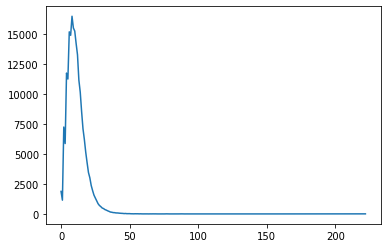

In [118]:
sentences=[]
for x in _df.trimed_text:
  sentences +=(x.split('，'))
sentences_df = pd.DataFrame(sentences)
sentences_df[0].str.len().value_counts().sort_index().plot()

## 將文章按照標點符號拆成句子

In [119]:
def split_sentence(_df):
  sentences_pair = []
  for x in _df.iterrows():
    for s in x[1]['trimed_text'].split('，'):
      sentence = s
      query = x[1]['query']
      relevance = x[1]['relevance']
      idx = x[0]
      sentences_pair.append([query,sentence,relevance,idx])
  col_names = ['query','sentence','idx','relevance']
  return pd.DataFrame(sentences_pair,columns=col_names)

target_df = split_sentence(_df)

empty_title = ((target_df['query'].isnull()) \
               | (target_df['sentence'].isnull()) \
               | (target_df['sentence'] == '') \
               | (target_df['sentence'] == '0')) \
               | (target_df['sentence'].str.len() > 100)
target_df = target_df[~empty_title]

target_df.sample(10)

,query,sentence,idx,relevance
89011,贊同課綱微調,民進黨及獨派媒體誓死反對,1,1446
64384,國際賽事會場內應該可以持中華民國國旗,神采奕奕熱烈的歡迎歸來的跑者,1,1022
119411,十二年國教高中職「免學費補助」適用對象增加是不對的,王建煊日前與媒體茶敘表示,1,1951
6426,支持陳前總統保外就醫,扁罹患冠心症,0,126
45763,國際賽事會場內應該可以持中華民國國旗,即將出任中華民國駐美代表的沈呂巡是清末兩江總督沈葆禎及欽差大臣林則徐的後人,1,726
48330,國際賽事會場內應該可以持中華民國國旗,葛姐身為台灣人,1,774
67710,國際賽事會場內應該可以持中華民國國旗,體育歸體育」的原則,1,1075
53676,國際賽事會場內應該可以持中華民國國旗,會不會變成恐怖份子,2,865
172610,應該提高酒駕罰責以有效遏制酒駕,還有附議人出席,2,2792
173347,應該提高酒駕罰責以有效遏制酒駕,(中時),1,2806


## 總句數約十四萬

In [120]:
target_df.count()

query        215167
sentence     215167
idx          215167
relevance    215167
dtype: int64

## 存檔備用

In [0]:
target_df.columns = ['text_a','text_b','label','idx']
target_df.to_csv('./test_ir_data.tsv', index=False, sep='\t', encoding='utf-8')

# BERT 訓練資料 **FakeNews**

In [122]:
df_train = pd.read_csv(path + "fakenews_train.csv")
empty_title = ((df_train['title2_zh'].isnull()) \
               | (df_train['title1_zh'].isnull()) \
               | (df_train['title2_zh'] == '') \
               | (df_train['title2_zh'] == '0'))
df_train = df_train[~empty_title]

# 剔除過長的樣本以避免 BERT 無法將整個輸入序列放入記憶體不多的 GPU
MAX_LENGTH = 30
df_train = df_train[~(df_train.title1_zh.apply(lambda x : len(x)) > MAX_LENGTH)]
df_train = df_train[~(df_train.title2_zh.apply(lambda x : len(x)) > MAX_LENGTH)]

# 去除不必要的欄位並重新命名兩標題的欄位名
df_train = df_train.reset_index()
df_train = df_train.loc[:, ['title1_zh', 'title2_zh', 'label']]
df_train.columns = ['text_a', 'text_b', 'label']

print("訓練樣本數：", len(df_train))
df_train.head()

訓練樣本數： 265693


,text_a,text_b,label
0,2017养老保险又新增两项，农村老人人人可申领，你领到了吗,警方辟谣“鸟巢大会每人领5万” 仍有老人坚持进京,unrelated
1,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",吃了30年食用油才知道，一片大蒜轻松鉴别地沟油,agreed
2,"""吃榴莲的禁忌,吃错会致命!","榴莲不能和什么一起吃 与咖啡同吃诱发心脏病""""",unrelated
3,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油",一颗大蒜就能鉴别地沟油？别闹了！做到下面几点，让您远离地沟油,agreed
4,"""用大蒜鉴别地沟油的方法,怎么鉴别地沟油","用一颗大蒜鉴别地沟油,非常实用!""",agreed


## 檢查訓練資料Label分布

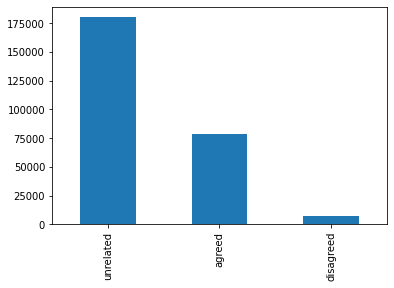

In [123]:
df_train.label.value_counts().plot(kind='bar')

## 調整訓練集資料分布

In [0]:
unrelated = df_train[df_train.label=='unrelated'].sample(15000)
agreed = df_train[df_train.label=='agreed'].sample(12000)
disagreed = df_train[df_train.label=='disagreed']
df_train = pd.concat([agreed,disagreed,unrelated]).reset_index(drop=True)

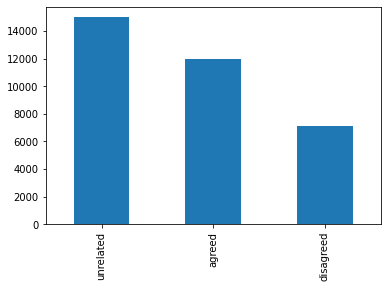

In [125]:
df_train.label.value_counts().plot(kind='bar')

## 存檔備用

In [0]:
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(df_train, random_state=777, train_size=0.8)
#存檔
train_data.to_csv('./train_ir_data.tsv', index=False, sep='\t', encoding='utf-8')
valid_data.to_csv('./valid_ir_data.tsv', index=False, sep='\t', encoding='utf-8')

## 資料集分別筆數
訓練集 27275

驗證集 6819

測試集 143989


In [127]:
print(len(train_data),len(valid_data),len(target_df))

27275 6819 215167


## 資料集讀取Function

In [0]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
from IPython.display import clear_output
PRETRAINED_MODEL_NAME = "bert-base-chinese"  # 指定繁簡中文 BERT-BASE 預訓練模型
# 取得此預訓練模型所使用的 tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
class IRDataset(Dataset):
    # 讀取前處理後的 tsv 檔並初始化一些參數
    def __init__(self, mode, tokenizer):
        assert mode in ["train", "valid", "test"]  # 一般訓練你會需要 dev set
        self.mode = mode
        # 大數據你會需要用 iterator=True
        self.df = pd.read_csv( mode + "_ir_data.tsv",sep='\t').fillna("")
        self.len = len(self.df)
        self.label_map = {'agreed': 0, 'disagreed': 1, 'unrelated': 2}
        self.tokenizer = tokenizer  # 我們將使用 BERT tokenizer
    
    # 定義回傳一筆訓練 / 測試數據的函式
    def __getitem__(self, idx):
        if self.mode == "train":
          text_a, text_b, label  = self.df.iloc[idx, :].values
          # 將 label 文字也轉換成索引方便轉換成 tensor
          label_id = self.label_map[label]
          label_tensor = torch.tensor(label_id)
  
        else:
          text_a, text_b = self.df.iloc[idx, :2].values
          label_tensor = None

          
        # 建立第一個句子的 BERT tokens 並加入分隔符號 [SEP]
        word_pieces = ["[CLS]"]
        tokens_a = self.tokenizer.tokenize(text_a)
        word_pieces += tokens_a + ["[SEP]"]
        len_a = len(word_pieces)
        
        # 第二個句子的 BERT tokens
        tokens_b = self.tokenizer.tokenize(text_b)
        word_pieces += tokens_b + ["[SEP]"]
        len_b = len(word_pieces) - len_a
        
        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # 將第一句包含 [SEP] 的 token 位置設為 0，其他為 1 表示第二句
        segments_tensor = torch.tensor([0] * len_a + [1] * len_b, 
                                        dtype=torch.long)
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
# 初始化一個專門讀取訓練樣本的 Dataset，使用中文 BERT 斷詞
trainset = IRDataset("train", tokenizer=tokenizer)

## 檢查資料讀取狀況

In [129]:
# 選擇第一個樣本
sample_idx = 99

# 將原始文本拿出做比較
text_a, text_b ,label= trainset.df.iloc[sample_idx].values

# 利用剛剛建立的 Dataset 取出轉換後的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 將 tokens_tensor 還原成文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)

# 渲染前後差異，毫無反應就是個 print。可以直接看輸出結果
print(f"""[原始文本]
句子 1：{text_a}
句子 2：{text_b}
分類  ：{label}

--------------------

[Dataset 回傳的 tensors]
tokens_tensor  ：{tokens_tensor}

segments_tensor：{segments_tensor}

label_tensor   ：{label_tensor}

--------------------

[還原 tokens_tensors]
{combined_text}
""")

[原始文本]
句子 1：11月10号今日淘宝双十一天猫密令红包 双11支付宝红包口令
句子 2：【正式辟谣！天猫双11不停售，吃瓜群众可
分類  ：unrelated

--------------------

[Dataset 回傳的 tensors]
tokens_tensor  ：tensor([ 101, 8111, 3299, 8108, 1384,  791, 3189, 3905, 2140, 1352, 1282,  671,
        1921, 4344, 2166,  808, 5273, 1259, 1352, 8111, 3118,  802, 2140, 5273,
        1259, 1366,  808,  102,  523, 3633, 2466, 6792, 6469, 8013, 1921, 4344,
        1352, 8111,  679,  977, 1545, 8024, 1391, 4478, 5408,  830, 1377,  102])

segments_tensor：tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

label_tensor   ：2

--------------------

[還原 tokens_tensors]
[CLS]11月10号今日淘宝双十一天猫密令红包双11支付宝红包口令[SEP]【正式辟谣！天猫双11不停售，吃瓜群众可[SEP]



## 批次載入資料 Function

In [0]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# 這個函式的輸入 `samples` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `FakeNewsDataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對前兩個 tensors 作 zero padding，並產生前面說明過的 masks_tensors
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # 測試集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # zero pad 到同一序列長度
    tokens_tensors = pad_sequence(tokens_tensors, 
                                  batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, 
                                    batch_first=True)
    
    # attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, 
                                dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(
        tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# 初始化一個每次回傳 64 個訓練樣本的 DataLoader
# 利用 `collate_fn` 將 list of samples 合併成一個 mini-batch 是關鍵
BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, 
                         collate_fn=create_mini_batch)

## 檢查模型參數

In [131]:
# 載入一個可以做中文多分類任務的模型，n_class = 3
from transformers import BertForSequenceClassification

PRETRAINED_MODEL_NAME = "bert-base-chinese"
NUM_LABELS = 3

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)

clear_output()

# high-level 顯示此模型裡的 modules
print("""
name            module
----------------------""")
for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print(f"{name}:{n}")
    else:
        print("{:15} {}".format(name, module))


name            module
----------------------
bert:embeddings
bert:encoder
bert:pooler
dropout         Dropout(p=0.1, inplace=False)
classifier      Linear(in_features=768, out_features=3, bias=True)


## 模型預測Function

In [0]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
      
    with torch.no_grad():
        # 遍巡整個資料集
        for data in dataloader:
            # 將所有 tensors 移到 GPU 上
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            
            # 別忘記前 3 個 tensors 分別為 tokens, segments 以及 masks
            # 且強烈建議在將這些 tensors 丟入 `model` 時指定對應的參數名稱
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)
            
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            # 用來計算訓練集的分類準確率
            if compute_acc:
                labels = data[3]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            # 將當前 batch 記錄下來
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions

# 開始 FineTune Bert Sequence 模型

In [18]:
%%time

#有GPU用GPU，沒有的話就用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
#將目前 model 上的數值都 Copy 一份到 device 上
#後續將在該device上操作
model = model.to(device)
model.train()
#優化器選用Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
#跑6個epoch
#EPOCHS = 6 
for epoch in range(EPOCHS):
    running_loss = 0.0
    # 1 個epoch 跑 n 次Batch
    # 每次 batch 都是一個step
    for data in trainloader:
        #找trainloader拿資料
        #分別放置對應的 list變數
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]
        #歸零梯度參數
        optimizer.zero_grad()
        #將輸入值塞進 model
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        #此處output值第一個變數是loss
        #有提供label作為input時，第一個值會是loss
        #沒有提供時，第一個值會是logits
        loss = outputs[0]
        #反向傳播模型參數
        loss.backward()
        #優化器更新參數
        optimizer.step()

        running_loss += loss.item()
        
    _, acc = get_predictions(model, trainloader, compute_acc=True)

    print('[epoch %d] loss: %.3f, acc: %.3f' %
          (epoch + 1, running_loss, acc))
    

device: cuda:0
[epoch 1] loss: 196.256, acc: 0.867
[epoch 2] loss: 133.042, acc: 0.900
[epoch 3] loss: 108.404, acc: 0.927
[epoch 4] loss: 85.961, acc: 0.943
[epoch 5] loss: 69.715, acc: 0.956
[epoch 6] loss: 56.039, acc: 0.968
CPU times: user 24min 44s, sys: 16min 20s, total: 41min 4s
Wall time: 41min 9s


## FineTune完成，進行驗證

In [0]:
%%time
validset = IRDataset("valid", tokenizer=tokenizer)
validloader = DataLoader(validset, batch_size=256,collate_fn=create_mini_batch)

predictions = get_predictions(model, validloader)

index_map = {v: k for k, v in validset.label_map.items()}

valid_pred = pd.DataFrame({"Category": predictions.tolist()})
valid_pred['Category'] = valid_pred.Category.apply(lambda x: index_map[x])
valid_df = pd.concat([validset.df, valid_pred.loc[:, 'Category']], axis=1)


In [0]:
valid_df[valid_df.label != valid_df.Category]

## 驗證完成，進行預測
載入 model

In [19]:
model_path = '/content/drive/My Drive/Colab Notebooks/DocumentRetrivalModel'
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

model = model.to(device)
#為了解決 CUDA error: device-side assert triggered
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device: cuda:0


模型預測

In [29]:
%%time
# 建立測試集。這邊我們可以用跟訓練時不同的 batch_size，看你 GPU 多大
testset = IRDataset("test", tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=64, 
                        collate_fn=create_mini_batch)

# 用分類模型預測測試集
test_predictions = get_predictions(model, testloader)

CPU times: user 4min 8s, sys: 1min 2s, total: 5min 10s
Wall time: 5min 10s


檢查結果

In [64]:
# 用來將預測的 label id 轉回 label 文字
index_map = {v: k for k, v in testset.label_map.items()}
test_pred = pd.DataFrame({"Category": test_predictions.tolist()})
test_pred['Category'] = test_pred.Category.apply(lambda x: index_map[x])
test_df = pd.concat([testset.df, test_pred.loc[:, 'Category']], axis=1)
test_df.to_csv(path+'dr_sentence_result.csv',index=False,encoding='utf-8')
test_df.sample(10)

,text_a,text_b,label,idx,Category
90937,贊同課綱微調,但有上述的疏忽和漏洞,3,1493,unrelated
102505,贊成流浪動物零撲殺,棄養施以重罰,0,1700,unrelated
110104,核四應該啟用,重新被界定為活斷層,1,1813,unrelated
185536,應該提高酒駕罰責以有效遏制酒駕,「肇事逃逸罪(185-4)」等三罪名起訴,3,3052,unrelated
154417,遠雄大巨蛋工程應停工或拆除,若北市府查馬當台北市長時議約有不法,2,2478,unrelated
7335,年金改革應取消或應調降軍公教月退之優存利率十八趴,共同努力,2,139,unrelated
69955,國際賽事會場內應該可以持中華民國國旗,「我在國中也是運動員,1,1131,unrelated
64649,國際賽事會場內應該可以持中華民國國旗,美,1,1035,unrelated
206678,臺灣應開放含瘦肉精(萊克多巴胺)之美國牛肉進口,「台灣對(美國)牛肉採取的行動,2,3374,agreed
90480,贊同課綱微調,他認為把學生納入課綱代表是政治化動作,2,1486,unrelated


# 預測結果計算

## 檢視相關性

unrelate = 0

agreed , disagree = 1

加總 <每篇文章> 中與 query 有關 <句子數>

再對各 relevance 取平均值


In [134]:
score_map = {'agreed': 1, 'disagreed': 1, 'unrelated': 0}
test_df['RelevantSentences'] = test_df.Category.apply(lambda x: score_map[x])
article_score = test_df.groupby(['idx']).agg('mean').reset_index(drop=True)
result_df = pd.concat([_df,article_score['RelevantSentences']],axis=1)
result_df

,query,news,relevance,trimed_text,RelevantSentences
0,支持陳前總統保外就醫,前總統陳水扁律師團今天說，法務部若依醫療鑑定小組認定，准扁保外就醫，重視醫療人權，在國際能見...,2,前總統陳水扁律師團今天說，法務部若依醫療鑑定小組認定，准扁保外就醫，重視醫療人權，在國際能見...,0.021739
1,支持陳前總統保外就醫,2014.12.05，大家晚安！每天晚間為您彙整夜線最讚新聞，一起來看看今天的夜線最讚新聞有...,1,2014，12，05，大家晚安，每天晚間為您彙整夜線最讚新聞，一起來看看今天的夜線最讚新聞有...,0.023810
2,支持陳前總統保外就醫,針對法務部昨（8）日指若前總統陳水扁近半年病情確有變化，可再次提出保外就醫聲請，民主進步黨發...,3,針對法務部昨（8）日指若前總統陳水扁近半年病情確有變化，可再次提出保外就醫聲請，民主進步黨發...,0.166667
3,支持陳前總統保外就醫,前總統陳水扁申請重回民進黨，因爭議過大，受理的台北市黨部昨日以「逕送中央」方式，表達拒審態度...,1,前總統陳水扁申請重回民進黨，因爭議過大，受理的台北市黨部昨日以「逕送中央」方式，表達拒審態度...,0.000000
4,支持陳前總統保外就醫,高雄市政府今天舉行升旗典禮，市長陳菊呼籲，法務部矯正署盡速完成應做的行政程序，讓前總統陳水扁...,3,高雄市政府今天舉行升旗典禮，市長陳菊呼籲，法務部矯正署盡速完成應做的行政程序，讓前總統陳水扁...,0.096774
...,...,...,...,...,...
3512,臺灣應開放含瘦肉精(萊克多巴胺)之美國牛肉進口,經濟部長施顏祥日前表示，只要美牛問題一日不解，台美就難以啟動ＴＩＦＡ（台美貿易暨投資架構協定...,0,經濟部長施顏祥日前表示，只要美牛問題一日不解，台美就難以啟動ＴＩＦＡ（台美貿易暨投資架構協定...,0.033898
3513,臺灣應開放含瘦肉精(萊克多巴胺)之美國牛肉進口,立法院明天將召開臨時會，處理美牛問題。執政黨有人數優勢，只要下定決心，當然會過關。但是，這一...,0,立法院明天將召開臨時會，處理美牛問題，執政黨有人數優勢，只要下定決心，當然會過關，但是，這一...,0.063830
3514,臺灣應開放含瘦肉精(萊克多巴胺)之美國牛肉進口,記者鄒景雯／特稿看到昨天的就職大典，國民黨菁英與立委們真要好好思忖︰「隨人顧性命」這句俗諺的...,0,記者鄒景雯／特稿看到昨天的就職大典，國民黨菁英與立委們真要好好思忖︰「隨人顧性命」這句俗諺的...,0.018868
3515,臺灣應開放含瘦肉精(萊克多巴胺)之美國牛肉進口,行政院日昨宣布有條件開放含瘦肉精的美牛進口，將採取「牛豬分離」等四項原則，不過國內養牛養豬業...,0,行政院日昨宣布有條件開放含瘦肉精的美牛進口，將採取「牛豬分離」等四項原則，不過國內養牛養豬業...,0.040000


觀察 relevance 與 Bert判斷有出現相關句子數量的關係
(單位 %)


In [137]:
result_df.groupby(['relevance']).agg('mean')['RelevantSentences']  .reset_index(drop=True) * 100

0    3.111672
1    1.579929
2    4.279764
3    6.754181
Name: RelevantSentences, dtype: float64

## 觀察立場支持度

計算 <每篇文章> 中與 query 相關、無關及總句子數

agreed : 認同句數

agreed_ratio : 認同句占比

disagreed : 不認同句數

disagreed_ratio : 不認同句占比

unrelated : 無關句數

unrelated_ratio : 無關句占比

sentences_count 總句數


In [0]:
score_map = {'agreed': 1, 'disagreed': -1, 'unrelated': 0}
test_df['SentimentSentences'] = test_df.Category.apply(lambda x: score_map[x])

article_score = test_df.groupby(['idx','Category']).size().reset_index()
article_pivot = pd.pivot_table(article_score, values=0, index=['idx'],
                    columns=['Category'], aggfunc='sum').fillna(0)
result_df2 = pd.concat([_df,article_pivot],axis=1)
result_df2['sentences_count'] = result_df2['agreed'] + result_df2['disagreed'] + result_df2['unrelated']
result_df2['agreed_ratio'] = result_df2['agreed'] / result_df2['sentences_count']
result_df2['disagreed_ratio'] = result_df2['disagreed'] / result_df2['sentences_count']
result_df2['unrelated_ratio'] = result_df2['unrelated'] / result_df2['sentences_count']

In [113]:
result_df2.head()

,query,news,relevance,agreed,disagreed,unrelated,sentences_count,agreed_ratio,disagreed_ratio,unrelated_ratio
0,支持陳前總統保外就醫,前總統陳水扁律師團今天說，法務部若依醫療鑑定小組認定，准扁保外就醫，重視醫療人權，在國際能見...,2,1.0,0.0,45.0,46.0,0.021739,0.000000,0.978261
1,支持陳前總統保外就醫,2014.12.05，大家晚安！每天晚間為您彙整夜線最讚新聞，一起來看看今天的夜線最讚新聞有...,1,2.0,0.0,82.0,84.0,0.023810,0.000000,0.976190
2,支持陳前總統保外就醫,針對法務部昨（8）日指若前總統陳水扁近半年病情確有變化，可再次提出保外就醫聲請，民主進步黨發...,3,4.0,1.0,25.0,30.0,0.133333,0.033333,0.833333
3,支持陳前總統保外就醫,前總統陳水扁申請重回民進黨，因爭議過大，受理的台北市黨部昨日以「逕送中央」方式，表達拒審態度...,1,0.0,0.0,66.0,66.0,0.000000,0.000000,1.000000
4,支持陳前總統保外就醫,高雄市政府今天舉行升旗典禮，市長陳菊呼籲，法務部矯正署盡速完成應做的行政程序，讓前總統陳水扁...,3,3.0,0.0,28.0,31.0,0.096774,0.000000,0.903226


按照 relevance 做 Group By計算

In [139]:
result_df2.groupby(['relevance']).agg('mean').reset_index(drop=True) 

,agreed,disagreed,unrelated,sentences_count,agreed_ratio,disagreed_ratio,unrelated_ratio
0,1.286783,0.339152,58.374065,60.000000,0.024785,0.006331,0.968883
1,0.745443,0.098680,64.029541,64.873664,0.013862,0.001937,0.984201
2,1.596021,0.417820,54.439446,56.453287,0.033683,0.009114,0.957202
3,2.699187,0.479675,58.157182,61.336043,0.057757,0.009785,0.932458


##結論
1.需要更乾淨的資料集來訓練模型
> 
2.Query 與 句子 的相關性Label 與預測結果相符

3.Query 與 句子 的支持程度 不太明顯
- unrelate 與 (agree + disagree) 的區別程度不高<br />
- 新聞資料的 Relevance 定義不清，似乎包含支持度資訊<br />(0為相關但不支持,<br /> 1的相關句數與支持分數都最低)

